In [57]:
from pm4py.objects.log.importer.xes import importer as xes_import_factory
import pm4py

from pandas.api.types import is_numeric_dtype
import pingouin as pg

import pandas as pd
import numpy as np
import scipy

In [58]:
# ignore this part in true PowerBI executions
import os
import pandas as pd
from pm4py.objects.log.util import dataframe_utils

from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics
from pm4py.statistics.attributes.pandas import get as attributes_get
from pm4py.statistics.start_activities.pandas import get as sa_get
from pm4py.statistics.end_activities.pandas import get as ea_get
from pm4py.visualization.dfg import visualizer


In [59]:
import tempfile

from pm4py.visualization.common import save
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import ipywidgets as widgets

In [71]:
def clean_df(df):

    explode_df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
    explode_df['time:timestamp'] = explode_df[['intime', 'outtime']].values.tolist()
    explode_df['a'] = 'start'
    explode_df['b'] = 'complete'
    explode_df['lifecycle:transition'] = explode_df[['a', 'b']].values.tolist()
    explode_df = explode_df.explode(['time:timestamp', 'lifecycle:transition'])
    explode_df.drop(['intime', 'outtime', 'a', 'b'], axis=1 ,inplace=True)
    explode_df['concept:name'] = explode_df['department']
    explode_df['case:concept:name'] = explode_df['subject_id']
    return explode_df

In [73]:
csv_data = pd.read_csv('../Event Logs_2nd_Iteration/Heart_Failure_Log.csv')
csv_data = clean_df(csv_data)
csv_data

,subject_id,hadm_id,transfer_id,department,Glucose,Abnormal Glucose,Potassium,Abnormal Potassium,Sodium,Abnormal Sodium,...,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,time:timestamp,lifecycle:transition,concept:name,case:concept:name
0,10559183,20008400.0,31433513,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 13:32:00,start,Emergency Department,10559183
0,10559183,20008400.0,31433513,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 16:00:00,complete,Emergency Department,10559183
1,10559183,20008400.0,36107959,Cardiac ICU,164.000000,1.0,4.316667,1.0,134.833333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 16:00:00,start,Cardiac ICU,10559183
1,10559183,20008400.0,36107959,Cardiac ICU,164.000000,1.0,4.316667,1.0,134.833333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-06 18:44:57,complete,Cardiac ICU,10559183
2,10559183,20008400.0,38390977,Post-ICU Cardiology,125.000000,1.0,4.300000,2.0,137.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-06 18:44:57,start,Post-ICU Cardiology,10559183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,11282384,29994261.0,30592303,Surgical ICU,138.833333,1.0,4.000000,2.0,142.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-21 18:35:27,complete,Surgical ICU,11282384
4321,11282384,29994261.0,37585480,Post-ICU Medicine,114.333333,1.0,4.466667,2.0,142.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-21 18:35:27,start,Post-ICU Medicine,11282384
4321,11282384,29994261.0,37585480,Post-ICU Medicine,114.333333,1.0,4.466667,2.0,142.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-24 13:13:59,complete,Post-ICU Medicine,11282384
4322,11282384,29994261.0,39587256,Discharged,123.000000,1.0,4.300000,2.0,140.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-24 13:13:59,start,Discharged,11282384


In [74]:
subject_over_60  = csv_data[csv_data['age']>60]['subject_id']
subject_under_60  = csv_data[csv_data['age']<=60]['subject_id']
over_60 = csv_data[csv_data['subject_id'].isin(subject_over_60)]
under_60 = csv_data[csv_data['subject_id'].isin(subject_under_60)]

In [75]:
def prepare_dataframe_mean_per_activity_measurement(df):
    
    df_meaned = df.groupby(["case:concept:name", "concept:name"]).mean()
    df_aggregated = df_meaned.groupby(['concept:name']).agg(lambda x: x.dropna().tolist())
    df_melted = pd.melt(df_aggregated.reset_index(), id_vars='concept:name',
           value_vars=df_aggregated.columns
    )
    df_final = df_melted[df_melted['value'].map(lambda d: len(d)) > 0]
    return df_final.set_index(['concept:name', 'variable'])

In [76]:
def prepare_dataframe_mode_per_activity_measurement(df):
    
    df_meaned = df.groupby(["case:concept:name", "concept:name"])[list(df.select_dtypes(exclude=['datetimetz', "number","bool_", "datetime"]).columns)].agg(lambda x: scipy.stats.mode(x)[0])
    df_aggregated = df_meaned.groupby(['concept:name']).agg(lambda x: x.dropna().tolist())
    df_melted = pd.melt(df_aggregated.reset_index(), id_vars='concept:name',
           value_vars=df_aggregated.columns
    )
    df_final = df_melted[df_melted['value'].map(lambda d: len(d)) > 0]
    return df_final.set_index(['concept:name', 'variable'])

In [77]:
def join_prepared_dataframes(d1, d2):
    return d1.join(d2, on=['concept:name', 'variable'], lsuffix='_l', rsuffix='_r')

In [78]:
def do_mwu(row):
    mwu_results = pg.mwu(row["value_l"], row["value_r"])
    row['p-val'] = mwu_results['p-val'][0]
    row['RBC'] = mwu_results['RBC'][0]
    row['RBC_abs'] = abs(mwu_results['RBC'][0])
    row['CLES'] = mwu_results['CLES'][0]
    return row

In [124]:
def do_chi_squared(row):
    
    left_df = pd.DataFrame(row["value_l"],columns =['values'])
    left_df['category'] = 'left'
    right_df = pd.DataFrame(row["value_r"],columns =['values'])
    right_df['category'] = 'right'
    df_concat = pd.concat([left_df, right_df])
    try:
        _, _, stats = pg.chi2_independence(df_concat, x='category', y='values')
        pearson_stats = stats[stats['test'] == 'pearson']
    except:
        pearson_stats = pd.Dataframe([100.0, 100.0, np.nan, np.nan, np.nan],columns=['pval', 'chi2', 'dof', 'power', 'cramer'])
    row['p-val'] = pearson_stats['pval'][0]
    row['chi2'] = pearson_stats['chi2'][0]
    row['dof'] = pearson_stats['dof'][0]
    # pval und chi2 value for comparison
    row['power'] = pearson_stats['power'][0]
    row['cramer'] = pearson_stats['cramer'][0]
    return row

In [109]:
# mean whitney u test

In [80]:
over_60_meaned = prepare_dataframe_mean_per_activity_measurement(over_60)
#over_60_meaned

In [81]:
under_60_meaned = prepare_dataframe_mean_per_activity_measurement(under_60)
#under_60_meaned

In [82]:
df_joined = join_prepared_dataframes(over_60_meaned, under_60_meaned)
#df_joined

In [83]:
mwu_results = df_joined.apply(do_mwu, axis=1)
#mwu_results

In [84]:
mwu_results["count_l"] = mwu_results.apply(lambda x: len(x["value_l"]), axis=1)
mwu_results["count_r"] = mwu_results.apply(lambda x: len(x["value_r"]), axis=1)
#mwu_results

In [85]:
# bonferroni correction
mwu_results["p-val-threshold"] = mwu_results.apply(lambda x: 0.05 / min(len(x["value_l"]), len(x["value_r"])), axis=1)
mwu_results = mwu_results[mwu_results["p-val"] < mwu_results["p-val-threshold"]]
#mwu_results

In [86]:
#sort values
mwu_results = mwu_results.sort_values(["concept:name", "RBC_abs"], ascending=False)
#mwu_results

In [87]:
#mwu_results.groupby("concept:name").head(5)

In [31]:
# top measurements for activities
mwu_results.groupby("concept:name").head(5).reset_index()[['concept:name', 'variable', 'RBC', 'p-val']]

# DBP only is super interesting -> no SBP

,concept:name,variable,RBC,p-val
0,Surgical ICU,DBP,0.493190,4.155474e-06
1,Surgical ICU,Temperature F,0.354618,9.413181e-04
2,Pre-ICU Cardiology,Urea Nitrogen,-0.498641,1.526282e-03
3,Pre-ICU Cardiology,Magnesium,-0.465473,2.381893e-03
4,Post-ICU Medicine,pH,0.484477,1.946342e-03
5,Post-ICU Medicine,PT,-0.369466,8.042031e-04
6,Post-ICU Medicine,INR(PT),-0.368593,7.906411e-04
7,Post-ICU Medicine,Phosphate,0.319363,1.073295e-04
8,Post-ICU Medicine,Abnormal INR(PT),0.285060,4.362156e-04
9,Post-ICU Cardiology,MCV,-0.265650,6.793420e-05


In [88]:
def get_best_mwu_for_activity_filtered(df_mwu, activity, allowed_measurements='ALL'):
    df_mwu = df_mwu.reset_index()
    if allowed_measurements != "ALL":
        df_mwu = df_mwu[df_mwu['variable'].isin(allowed_measurements)]
    top_mwu = df_mwu.groupby("concept:name").head(1)
    res = top_mwu.reset_index().loc[top_mwu.reset_index()["concept:name"] == activity, "RBC_abs"]
    if len(res.values) > 0:
        return res.values[0]
    else:
        return 0

In [ ]:
# chi squared start

In [125]:
over_60_mode = prepare_dataframe_mode_per_activity_measurement(over_60)
over_60_mode
under_60_mode = prepare_dataframe_mode_per_activity_measurement(under_60)
under_60_mode
df_joined_mode = join_prepared_dataframes(over_60_mode, under_60_mode)
chi_results = df_joined_mode.apply(do_chi_squared, axis=1)
#chi_results

/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6713: RuntimeWarning: divide by zero encountered in tru

In [126]:
# bonferroni correction
chi_results["p-val-threshold"] = chi_results.apply(lambda x: 0.05 / min(len(x["value_l"]), len(x["value_r"])), axis=1)
chi_results = chi_results[chi_results["p-val"] < chi_results["p-val-threshold"]]
chi_results

value_l  \
concept:name         variable                                                                
Emergency Department insurance           [Medicare, Other, Medicare, Medicare, Medicare...   
                     ethnicity           [WHITE, UNKNOWN, WHITE, WHITE, WHITE, WHITE, W...   
                     marital_status      [WIDOWED, 0, MARRIED, WIDOWED, WIDOWED, MARRIE...   
Discharged           discharge_location  [DIED, HOME HEALTH CARE, HOME HEALTH CARE, SKI...   

                                                                                   value_r  \
concept:name         variable                                                                
Emergency Department insurance           [Other, Medicare, Medicare, Other, Other, Othe...   
                     ethnicity           [WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, HIS...   
                     marital_status      [SINGLE, WIDOWED, DIVORCED, MARRIED, SINGLE, D...   
Discharged           discharge_location  [HOME, DIED, HOME HEALTH CARE, HOME, REHAB, HO...   

                                                p-val        chi2   dof  \
concept:name         variable                                             
Emergency Department insurance           1.412985e-24  109.832675   2.0   
                     ethnicity           3.560489e-09   53.088778   7.0   
                     marital_status      3.748947e-25  120.719818   4.0   
Discharged           discharge_location  4.877297e-24  140.441838  12.0   

                                           power    cramer  p-val-threshold  
concept:name         variable                                                
Emergency Department insurance           1.00000  0.342553         0.000263  
                     ethnicity           0.99998  0.238157         0.000263  
                     marital_status      1.00000  0.359130         0.000263  
Discharged           discharge_location  1.00000  0.387356         0.000263

In [127]:
chi_results = chi_results.sort_values(["concept:name", "p-val"], ascending=False)
chi_results
chi_results.groupby("concept:name").head(5)

value_l  \
concept:name         variable                                                                
Emergency Department ethnicity           [WHITE, UNKNOWN, WHITE, WHITE, WHITE, WHITE, W...   
                     insurance           [Medicare, Other, Medicare, Medicare, Medicare...   
                     marital_status      [WIDOWED, 0, MARRIED, WIDOWED, WIDOWED, MARRIE...   
Discharged           discharge_location  [DIED, HOME HEALTH CARE, HOME HEALTH CARE, SKI...   

                                                                                   value_r  \
concept:name         variable                                                                
Emergency Department ethnicity           [WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, HIS...   
                     insurance           [Other, Medicare, Medicare, Other, Other, Othe...   
                     marital_status      [SINGLE, WIDOWED, DIVORCED, MARRIED, SINGLE, D...   
Discharged           discharge_location  [HOME, DIED, HOME HEALTH CARE, HOME, REHAB, HO...   

                                                p-val        chi2   dof  \
concept:name         variable                                             
Emergency Department ethnicity           3.560489e-09   53.088778   7.0   
                     insurance           1.412985e-24  109.832675   2.0   
                     marital_status      3.748947e-25  120.719818   4.0   
Discharged           discharge_location  4.877297e-24  140.441838  12.0   

                                           power    cramer  p-val-threshold  
concept:name         variable                                                
Emergency Department ethnicity           0.99998  0.238157         0.000263  
                     insurance           1.00000  0.342553         0.000263  
                     marital_status      1.00000  0.359130         0.000263  
Discharged           discharge_location  1.00000  0.387356         0.000263

In [38]:
# chi squared end

In [128]:
dataset = dataframe_utils.convert_timestamp_columns_in_df(over_60)

# this part is required because the dataframe provided by PowerBI has strings
dataset["time:timestamp"] = pd.to_datetime(dataset["time:timestamp"])
dataset = dataset.sort_values("time:timestamp")

dataset

/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], utc=True, infer_datetime_format=True)
/var/folders/2z/hk7x37vj029gb48kv3xv2_hh0000gn/T/ipykernel_53904/2453440538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["time:timestamp"] = pd.to_datetime(dataset["time:timestamp"])


,subject_id,hadm_id,transfer_id,department,Glucose,Abnormal Glucose,Potassium,Abnormal Potassium,Sodium,Abnormal Sodium,...,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,time:timestamp,lifecycle:transition,concept:name,case:concept:name
4,14717666,20009241.0,31161240,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2110-05-24 21:16:00+00:00,start,Emergency Department,14717666
4,14717666,20009241.0,31161240,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2110-05-25 02:18:00+00:00,complete,Emergency Department,14717666
5,14717666,20009241.0,30130596,Cardiac ICU,123.750000,1.0,4.012500,2.0,139.750000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2110-05-25 02:18:00+00:00,start,Cardiac ICU,14717666
6,14717666,20009241.0,30018365,Post-ICU Cardiology,87.000000,2.0,4.014286,2.0,137.571429,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2110-05-29 13:20:37+00:00,start,Post-ICU Cardiology,14717666
5,14717666,20009241.0,30130596,Cardiac ICU,123.750000,1.0,4.012500,2.0,139.750000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2110-05-29 13:20:37+00:00,complete,Cardiac ICU,14717666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,14050349,28565011.0,36339938,Medical ICU,208.941176,1.0,4.646667,1.0,133.466667,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2208-06-12 22:56:00+00:00,start,Medical ICU,14050349
3713,14050349,28565011.0,32782489,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,116.0,72.0,NaN,2.0,"Found down, L Weakness",2208-06-12 22:56:00+00:00,complete,Emergency Department,14050349
3714,14050349,28565011.0,36339938,Medical ICU,208.941176,1.0,4.646667,1.0,133.466667,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2208-06-16 10:32:43+00:00,complete,Medical ICU,14050349
3715,14050349,28565011.0,36756042,Discharged,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2208-06-16 10:32:43+00:00,start,Discharged,14050349


In [129]:
dfg = df_statistics.get_dfg_graph(dataset, measure="frequency")
dfg

{('Cardiac ICU', 'Cardiac ICU'): 117,
 ('Cardiac ICU', 'Discharged'): 175,
 ('Cardiac ICU', 'Emergency Department'): 148,
 ('Cardiac ICU', 'Post-ICU Cardiology'): 291,
 ('Cardiac ICU', 'Post-ICU Medicine'): 30,
 ('Cardiac ICU', 'Post-ICU Surgery'): 9,
 ('Cardiac ICU', 'Pre-ICU Cardiology'): 56,
 ('Cardiac ICU', 'Pre-ICU Medicine'): 9,
 ('Cardiac ICU', 'Pre-ICU Surgery'): 1,
 ('Discharged', 'Cardiac ICU'): 36,
 ('Discharged', 'Discharged'): 425,
 ('Discharged', 'Emergency Department'): 81,
 ('Discharged', 'Medical ICU'): 20,
 ('Discharged', 'Post-ICU Cardiology'): 199,
 ('Discharged', 'Post-ICU Medicine'): 103,
 ('Discharged', 'Post-ICU Surgery'): 36,
 ('Discharged', 'Surgical ICU'): 8,
 ('Emergency Department', 'Cardiac ICU'): 377,
 ('Emergency Department', 'Discharged'): 22,
 ('Emergency Department', 'Emergency Department'): 411,
 ('Emergency Department', 'Medical ICU'): 262,
 ('Emergency Department', 'Post-ICU Cardiology'): 85,
 ('Emergency Department', 'Post-ICU Medicine'): 51,
 ('E

In [130]:
activities_count = attributes_get.get_attribute_values(dataset, "concept:name")
start_activities = sa_get.get_start_activities(dataset)
end_activities = ea_get.get_end_activities(dataset)

In [131]:
activities_count

{'Emergency Department': 1654,
 'Discharged': 1654,
 'Cardiac ICU': 836,
 'Post-ICU Cardiology': 788,
 'Medical ICU': 492,
 'Post-ICU Medicine': 488,
 'Surgical ICU': 326,
 'Pre-ICU Cardiology': 256,
 'Post-ICU Surgery': 152,
 'Pre-ICU Medicine': 142,
 'Pre-ICU Surgery': 22}

In [132]:
for activity in activities_count:
    print(activity)
    activities_count[activity] = get_best_mwu_for_activity_filtered(mwu_results, activity)
activities_count

Emergency Department
Discharged
Cardiac ICU
Post-ICU Cardiology
Medical ICU
Post-ICU Medicine
Surgical ICU
Pre-ICU Cardiology
Post-ICU Surgery
Pre-ICU Medicine
Pre-ICU Surgery


{'Emergency Department': 1.0,
 'Discharged': 0.30703624733475476,
 'Cardiac ICU': 0.5075880758807588,
 'Post-ICU Cardiology': 0.462962962962963,
 'Medical ICU': 0.3960244648318043,
 'Post-ICU Medicine': 0.4844771241830066,
 'Surgical ICU': 0.4931899641577061,
 'Pre-ICU Cardiology': 0.49864130434782616,
 'Post-ICU Surgery': 0.4449275362318841,
 'Pre-ICU Medicine': 0.6666666666666667,
 'Pre-ICU Surgery': 1.0}

In [38]:
allowed_measurements = ['age', 'Phosphate', 'Sodium']
for activity in activities_count:
    print(activity)
    activities_count[activity] = get_best_mwu_for_activity_filtered(mwu_results, activity, allowed_measurements)
activities_count

Emergency Department
Discharged
Cardiac ICU
Post-ICU Cardiology
Medical ICU
Post-ICU Medicine
Surgical ICU
Pre-ICU Cardiology
Post-ICU Surgery
Pre-ICU Medicine
Pre-ICU Surgery


{'Emergency Department': 1.0,
 'Discharged': 0.29304160688665715,
 'Cardiac ICU': 0,
 'Post-ICU Cardiology': 0,
 'Medical ICU': 0,
 'Post-ICU Medicine': 0.3193633952254642,
 'Surgical ICU': 0,
 'Pre-ICU Cardiology': 0,
 'Post-ICU Surgery': 0,
 'Pre-ICU Medicine': 0,
 'Pre-ICU Surgery': 0}

In [39]:
start_activities

{'Emergency Department': 746}

In [40]:
end_activities

{'Discharged': 746}

In [134]:
gviz = visualizer.apply(dfg, activities_count=activities_count, variant=visualizer.Variants.FREQUENCY,
                        parameters={"start_activities": start_activities, "end_activities": end_activities, "maxNoOfEdgesInDiagram": 20})

#gviz to print svg

<IPython.core.display.Javascript object>


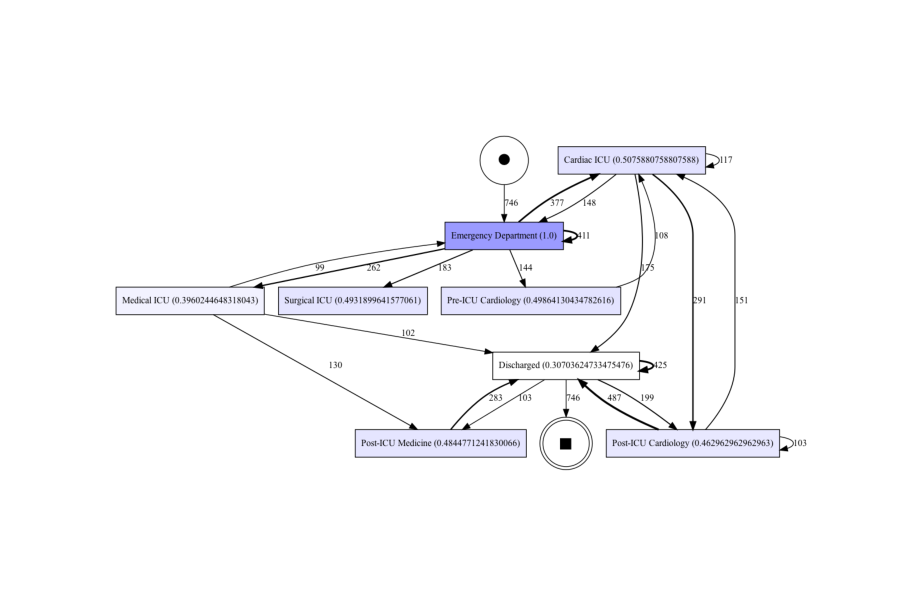

In [135]:
%matplotlib notebook
fig = plt.figure(figsize=(9,6))

file_name = tempfile.NamedTemporaryFile(suffix='.png')
file_name.close()

save.save(gviz, file_name.name)

img = mpimg.imread(file_name.name)
plt.axis('off')
plt.imshow(img)
plt.show()


In [53]:
# test auf categorical vars
# chi squared fixen -> Hendrik

# summary bauen für: measurement x ist für activity y significant

# interactivity of matplotlib -> after präsi 

# -> dann zwischenpräsi bauen
# -> kleine Demo bauen
# Zwischenpräsi:
# problem erklären (motivation + related work) -> Vinc
# approach -> datenbasiert + stat. siginifikant -> zusammen
# test erklären -> Hendrik
# Demo -> zusammen
# next steps (behavior, pm4py integration) -> Hendrik

# wir können Präsi an Jonas schicken
# präsi an Jonas schicken: Jan 1 Abends

In [139]:
def build_visualization(dfg, max_nodes, measurements):
    print(f"used measurements: {measurements}")
    for activity in activities_count:
        activities_count[activity] = get_best_mwu_for_activity_filtered(mwu_results, activity, measurements)
    gviz = visualizer.apply(dfg, activities_count=activities_count, variant=visualizer.Variants.FREQUENCY,
                        parameters={"start_activities": start_activities, "end_activities": end_activities, "maxNoOfEdgesInDiagram": max_nodes})

    fig = plt.figure(figsize=(9,6))

    file_name = tempfile.NamedTemporaryFile(suffix='.png')
    file_name.close()

    save.save(gviz, file_name.name)

    img = mpimg.imread(file_name.name)
    plt.axis('off')
    plt.imshow(img)
    plt.show() 
    display(
mwu_results.reset_index()[mwu_results.reset_index()['variable'].isin(list(measurements_widget.value))].groupby("concept:name").head(5)[['concept:name', 'variable', 'RBC', 'p-val']].set_index(['concept:name', 'variable']))

In [136]:
# ipywidget integration

max_nodes_widget = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    description='Max Number of Nodes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

measurements_widget  = widgets.SelectMultiple(
    options=mwu_results.reset_index()['variable'],
    value=['age'],
    #rows=10,
    description='Measurements',
    disabled=False
)



In [137]:
display(max_nodes_widget)
display(measurements_widget)

IntSlider(value=10, continuous_update=False, description='Max Number of Nodes:')

SelectMultiple(description='Measurements', index=(460,), options=('DBP', 'Temperature F', 'pO2', 'MCH', 'MCHC'…

used measurements: ('age',)


<IPython.core.display.Javascript object>


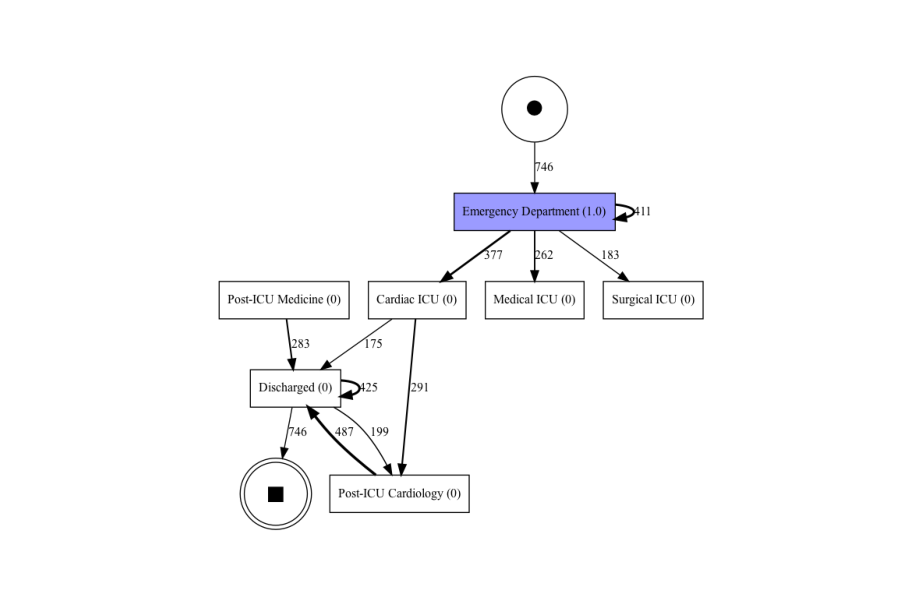

,,RBC,p-val
concept:name,variable,,
Emergency Department,age,-1.0,7.088673e-101


In [140]:
build_visualization(dfg, max_nodes_widget.value, measurements_widget.value)

In [71]:
# show Auswertungstabelle mit Werten aus Graph! -> w/ filter from ipywidgets
mwu_results.reset_index()[mwu_results.reset_index()['variable'].isin(list(measurements_widget.value))].groupby("concept:name").head(5)[['concept:name', 'variable', 'RBC', 'p-val']].set_index(['concept:name', 'variable'])

RBC         p-val
concept:name        variable                                
Surgical ICU        DBP               0.493190  4.155474e-06
                    Temperature F     0.354618  9.413181e-04
Pre-ICU Cardiology  Urea Nitrogen    -0.498641  1.526282e-03
                    Magnesium        -0.465473  2.381893e-03
Post-ICU Medicine   pH                0.484477  1.946342e-03
                    PT               -0.369466  8.042031e-04
                    INR(PT)          -0.368593  7.906411e-04
                    Phosphate         0.319363  1.073295e-04
                    Abnormal INR(PT)  0.285060  4.362156e-04
Post-ICU Cardiology MCV              -0.265650  6.793420e-05
                    Red Blood Cells   0.239437  3.305883e-04
Medical ICU         DBP               0.396024  1.700985e-06
                    Temperature F     0.384793  3.854910e-06
                    PT               -0.353825  8.966515e-05
                    INR(PT)          -0.323968  3.283458e-04
Discharged          Phosphate         0.293042  4.192497e-08
                    MCV              -0.220124  5.032724e-05
Cardiac ICU         DBP               0.507588  6.724052e-15
                    Urea Nitrogen    -0.302282  3.045820e-06
                    MCV              -0.300367  4.864896e-06
                    Temperature F     0.269106  3.861002e-05

In [70]:
mwu_results.reset_index()[mwu_results.reset_index()['variable'].isin(list(measurements_widget.value))].groupby("concept:name").head(5)

,concept:name,variable,value_l,value_r,p-val,RBC,RBC_abs,CLES,count_l,count_r,p-val-threshold
0,Surgical ICU,DBP,"[54.65217391304348, 69.4, 72.73684210526315, 5...","[71.04444444444445, 63.0625, 56.80745341614906...",4.155474e-06,0.493190,0.493190,0.253405,155,36,0.001389
1,Surgical ICU,Temperature F,"[96.5923076923077, 98.64, 97.98, 98.42, 98.025...","[98.7409090909091, 98.6, 98.15833333333333, 98...",9.413181e-04,0.354618,0.354618,0.322691,154,36,0.001389
2,Pre-ICU Cardiology,Urea Nitrogen,"[37.75, 54.42857142857143, 33.25, 125.10526315...","[35.25, 13.0, 64.5, 24.4, 58.5, 19.66666666666...",1.526282e-03,-0.498641,0.498641,0.749321,92,16,0.003125
3,Pre-ICU Cardiology,Magnesium,"[1.8666666666666665, 2.733333333333334, 2.225,...","[2.125, 1.9, 2.1333333333333333, 1.75, 1.85, 1...",2.381893e-03,-0.465473,0.465473,0.732737,92,17,0.002941
4,Post-ICU Medicine,pH,"[7.38, 7.0, 6.955, 6.0, 7.42, 7.4, 6.0, 6.7566...","[7.373333333333334, 7.0, 7.35, 7.3, 7.44, 6.5,...",1.946342e-03,0.484477,0.484477,0.257761,72,17,0.002941
5,Post-ICU Medicine,PT,"[26.73333333333333, 15.393478260869564, 12.7, ...","[12.3, 22.6, 16.7, 11.9, 13.8, 12.2, 11.9, 21....",8.042031e-04,-0.369466,0.369466,0.684733,131,35,0.001429
6,Post-ICU Medicine,INR(PT),"[2.6666666666666665, 1.4108695652173913, 1.2, ...","[1.1, 2.1, 1.5, 1.1, 1.3, 1.15, 1.1, 1.95, 1.1...",7.906411e-04,-0.368593,0.368593,0.684297,131,35,0.001429
7,Post-ICU Medicine,Phosphate,"[2.566666666666667, 5.6000000000000005, 4.225,...","[3.266666666666667, 3.383333333333333, 3.5, 4....",1.073295e-04,0.319363,0.319363,0.340318,203,65,0.000769
8,Post-ICU Medicine,Abnormal INR(PT),"[1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...","[2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, ...",4.362156e-04,0.285060,0.285060,0.357470,131,35,0.001429
10,Post-ICU Cardiology,MCV,"[79.5, 98.22222222222224, 93.75, 85.5454545454...","[74.0, 95.0, 88.66666666666669, 94.33333333333...",6.793420e-05,-0.265650,0.265650,0.632825,359,95,0.000526


In [64]:
def graphviz_visualization(activities_count, dfg, image_format="png", measure="frequency",
                           max_no_of_edges_in_diagram=100000, start_activities=None, 
                           end_activities=None, soj_time=None, font_size="12", 
                           bgcolor="transparent"):
    """
    Do GraphViz visualization of a DFG graph
    Parameters
    -----------
    activities_count
        Count of attributes in the log (may include attributes that are not in the DFG graph)
    dfg
        DFG graph
    image_format
        GraphViz should be represented in this format
    measure
        Describes which measure is assigned to edges in direcly follows graph (frequency/performance)
    max_no_of_edges_in_diagram
        Maximum number of edges in the diagram allowed for visualization
    start_activities
        Start activities of the log
    end_activities
        End activities of the log
    soj_time
        For each activity, the sojourn time in the log
    stat_locale
        Dict to locale the stat strings
    
    Returns
    -----------
    viz
        Digraph object
    """
    if start_activities is None:
        start_activities = {}
    if end_activities is None:
        end_activities = {}

    filename = tempfile.NamedTemporaryFile(suffix='.gv')
    viz = Digraph("", filename=filename.name, engine='dot', graph_attr={'bgcolor': bgcolor})

    # first, remove edges in diagram that exceeds the maximum number of edges in the diagram
    dfg_key_value_list = []
    for edge in dfg:
        dfg_key_value_list.append([edge, dfg[edge]])
    # more fine grained sorting to avoid that edges that are below the threshold are
    # undeterministically removed
    dfg_key_value_list = sorted(dfg_key_value_list, key=lambda x: (x[1], x[0][0], x[0][1]), reverse=True)
    dfg_key_value_list = dfg_key_value_list[0:min(len(dfg_key_value_list), max_no_of_edges_in_diagram)]
    dfg_allowed_keys = [x[0] for x in dfg_key_value_list]
    dfg_keys = list(dfg.keys())
    for edge in dfg_keys:
        if edge not in dfg_allowed_keys:
            del dfg[edge]

    # calculate edges penwidth
    penwidth = assign_penwidth_edges(dfg)
    activities_in_dfg = set()
    activities_count_int = copy(activities_count)

    for edge in dfg:
        activities_in_dfg.add(edge[0])
        activities_in_dfg.add(edge[1])

    # assign attributes color
    activities_color = get_activities_color(activities_count_int)

    # represent nodes
    viz.attr('node', shape='box')

    if len(activities_in_dfg) == 0:
        activities_to_include = sorted(list(set(activities_count_int)))
    else:
        # take unique elements as a list not as a set (in this way, nodes are added in the same order to the graph)
        activities_to_include = sorted(list(set(activities_in_dfg)))

    activities_map = {}

    for act in activities_to_include:
        if "frequency" in measure and act in activities_count_int:
            viz.node(str(hash(act)), act + " (" + str(activities_count_int[act]) + ")", style='filled',
                     fillcolor=activities_color[act], fontsize=font_size)
            activities_map[act] = str(hash(act))
        else:
            stat_string = human_readable_stat(soj_time[act], stat_locale)
            viz.node(str(hash(act)), act + f" ({stat_string})", fontsize=font_size)
            activities_map[act] = str(hash(act))

    # make edges addition always in the same order
    dfg_edges = sorted(list(dfg.keys()))

    # represent edges
    for edge in dfg_edges:
        if "frequency" in measure:
            label = str(dfg[edge])
        else:
            label = human_readable_stat(dfg[edge], stat_locale)
        viz.edge(str(hash(edge[0])), str(hash(edge[1])), label=label, penwidth=str(penwidth[edge]), fontsize=font_size)

    start_activities_to_include = [act for act in start_activities if act in activities_map]
    end_activities_to_include = [act for act in end_activities if act in activities_map]

    if start_activities_to_include:
        viz.node("@@startnode", "<&#9679;>", shape='circle', fontsize="34")
        for act in start_activities_to_include:
            label = str(start_activities[act]) if isinstance(start_activities, dict) else ""
            viz.edge("@@startnode", activities_map[act], label=label, fontsize=font_size)

    if end_activities_to_include:
        # <&#9632;>
        viz.node("@@endnode", "<&#9632;>", shape='doublecircle', fontsize="32")
        for act in end_activities_to_include:
            label = str(end_activities[act]) if isinstance(end_activities, dict) else ""
            viz.edge(activities_map[act], "@@endnode", label=label, fontsize=font_size)

    viz.attr(overlap='false')

    viz.format = image_format

    return viz


In [ ]:
# buttonclick events in matplotlib figures (funktioniert bei heatmap und returned die Datenkoordinaten)